Open statement/Introduction

In this project, the focus is on bias correction for next-day maximum and minimum air temperatures forecasted by the Local Data Assimilation and Prediction System (LDAPS) model operated by the Korea Meteorological Administration for Seoul, South Korea. Utilizing summer data from 2013 to 2017, the project employs machine learning techniques to improve the accuracy of temperature predictions. The approach encompasses a comprehensive analysis of the dataset, including exploratory data analysis, preprocessing, feature engineering, model building, and evaluation, culminating in the selection of the best model for production use.

`1. Import Required Libraries and Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

2. Exploratory Data Analysis (EDA) and Preprocessing

In [2]:
# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/dsrscientist/Dataset2/main/temperature.csv')

In [3]:
df .head()

,station,Date,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,...,LDAPS_PPT2,LDAPS_PPT3,LDAPS_PPT4,lat,lon,DEM,Slope,Solar radiation,Next_Tmax,Next_Tmin
0,1.0,30-06-2013,28.7,21.4,58.255688,91.116364,28.074101,23.006936,6.818887,69.451805,...,0.0,0.0,0.0,37.6046,126.991,212.3350,2.7850,5992.895996,29.1,21.2
1,2.0,30-06-2013,31.9,21.6,52.263397,90.604721,29.850689,24.035009,5.691890,51.937448,...,0.0,0.0,0.0,37.6046,127.032,44.7624,0.5141,5869.312500,30.5,22.5
2,3.0,30-06-2013,31.6,23.3,48.690479,83.973587,30.091292,24.565633,6.138224,20.573050,...,0.0,0.0,0.0,37.5776,127.058,33.3068,0.2661,5863.555664,31.1,23.9
3,4.0,30-06-2013,32.0,23.4,58.239788,96.483688,29.704629,23.326177,5.650050,65.727144,...,0.0,0.0,0.0,37.6450,127.022,45.7160,2.5348,5856.964844,31.7,24.3
4,5.0,30-06-2013,31.4,21.9,56.174095,90.155128,29.113934,23.486480,5.735004,107.965535,...,0.0,0.0,0.0,37.5507,127.135,35.0380,0.5055,5859.552246,31.2,22.5


FIRST FIVE DATA FROM THE DATASET

Maximum temperatures ranged from 28.7°C to 32.0°C, while minimum temperatures varied from 21.4°C to 23.4°C across different stations.

Predicted humidity levels showed significant variation, but no precipitation was forecasted.

Solar radiation values suggested strong sunlight, with wind speeds indicating moderate conditions.

The dataset includes geographic details like latitude, longitude, elevation, and slope, which influence weather predictions.

The next day's temperature forecasts suggest minor changes, indicating stable weather conditions

In [4]:
df .info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7752 entries, 0 to 7751
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   station           7750 non-null   float64
 1   Date              7750 non-null   object 
 2   Present_Tmax      7682 non-null   float64
 3   Present_Tmin      7682 non-null   float64
 4   LDAPS_RHmin       7677 non-null   float64
 5   LDAPS_RHmax       7677 non-null   float64
 6   LDAPS_Tmax_lapse  7677 non-null   float64
 7   LDAPS_Tmin_lapse  7677 non-null   float64
 8   LDAPS_WS          7677 non-null   float64
 9   LDAPS_LH          7677 non-null   float64
 10  LDAPS_CC1         7677 non-null   float64
 11  LDAPS_CC2         7677 non-null   float64
 12  LDAPS_CC3         7677 non-null   float64
 13  LDAPS_CC4         7677 non-null   float64
 14  LDAPS_PPT1        7677 non-null   float64
 15  LDAPS_PPT2        7677 non-null   float64
 16  LDAPS_PPT3        7677 non-null   float64


There are some missing values, notably in temperature and precipitation forecasts.

Geographic details (latitude, longitude, elevation, slope) and solar radiation have complete data.

The 'Date' column is the only non-numeric data type.

Data spans current and predicted weather conditions, including temperature, humidity, and precipitation.

In [5]:
df .describe()

,station,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,LDAPS_CC1,...,LDAPS_PPT2,LDAPS_PPT3,LDAPS_PPT4,lat,lon,DEM,Slope,Solar radiation,Next_Tmax,Next_Tmin
count,7750.000000,7682.000000,7682.000000,7677.000000,7677.000000,7677.000000,7677.000000,7677.000000,7677.000000,7677.000000,...,7677.000000,7677.000000,7677.000000,7752.000000,7752.000000,7752.000000,7752.000000,7752.000000,7725.000000,7725.000000
mean,13.000000,29.768211,23.225059,56.759372,88.374804,29.613447,23.512589,7.097875,62.505019,0.368774,...,0.485003,0.278200,0.269407,37.544722,126.991397,61.867972,1.257048,5341.502803,30.274887,22.932220
std,7.211568,2.969999,2.413961,14.668111,7.192004,2.947191,2.345347,2.183836,33.730589,0.262458,...,1.762807,1.161809,1.206214,0.050352,0.079435,54.279780,1.370444,429.158867,3.128010,2.487613
min,1.000000,20.000000,11.300000,19.794666,58.936283,17.624954,14.272646,2.882580,-13.603212,0.000000,...,0.000000,0.000000,0.000000,37.456200,126.826000,12.370000,0.098475,4329.520508,17.400000,11.300000
25%,7.000000,27.800000,21.700000,45.963543,84.222862,27.673499,22.089739,5.678705,37.266753,0.146654,...,0.000000,0.000000,0.000000,37.510200,126.937000,28.700000,0.271300,4999.018555,28.200000,21.300000
50%,13.000000,29.900000,23.400000,55.039024,89.793480,29.703426,23.760199,6.547470,56.865482,0.315697,...,0.000000,0.000000,0.000000,37.550700,126.995000,45.716000,0.618000,5436.345215,30.500000,23.100000
75%,19.000000,32.000000,24.900000,67.190056,93.743629,31.710450,25.152909,8.032276,84.223616,0.575489,...,0.018364,0.007896,0.000041,37.577600,127.042000,59.832400,1.767800,5728.316406,32.600000,24.600000
max,25.000000,37.600000,29.900000,98.524734,100.000153,38.542255,29.619342,21.857621,213.414006,0.967277,...,21.621661,15.841235,16.655469,37.645000,127.135000,212.335000,5.178230,5992.895996,38.900000,29.800000


Average present maximum and minimum temperatures are approximately 29.77°C and 23.23°C, respectively.

Relative humidity varies widely, with mean minimum and maximum values around 56.76% and 88.37%.

Precipitation predictions are very low on average, suggesting minimal rainfall.

Next-day temperature forecasts show a slight increase, with averages around 30.27°C for max and 22.93°C for min.

In [6]:
df.isnull().sum()

station              2
Date                 2
Present_Tmax        70
Present_Tmin        70
LDAPS_RHmin         75
LDAPS_RHmax         75
LDAPS_Tmax_lapse    75
LDAPS_Tmin_lapse    75
LDAPS_WS            75
LDAPS_LH            75
LDAPS_CC1           75
LDAPS_CC2           75
LDAPS_CC3           75
LDAPS_CC4           75
LDAPS_PPT1          75
LDAPS_PPT2          75
LDAPS_PPT3          75
LDAPS_PPT4          75
lat                  0
lon                  0
DEM                  0
Slope                0
Solar radiation      0
Next_Tmax           27
Next_Tmin           27
dtype: int64

There are missing values in the dataset, with 'Present_Tmax', 'Present_Tmin', and all LDAPS variables each missing 75 entries.

The 'station' and 'Date' fields have the fewest missing values, with only 2 each.

Geographic details ('lat', 'lon', 'DEM', 'Slope') and 'Solar radiation' have complete data with no missing entries.

Predicted temperatures for the next day ('Next_Tmax' and 'Next_Tmin') are missing in 27 entries.

The consistency in the number of missing entries across most LDAPS variables suggests a pattern, possibly related to the same missing dates or stations.

In [7]:
# Dealing with missing data

# Median imputation for precipitation variables
median_imputer = SimpleImputer(strategy='median')
precipitation_features = ['LDAPS_PPT1', 'LDAPS_PPT2', 'LDAPS_PPT3', 'LDAPS_PPT4']
for feature in precipitation_features:
    df[feature] = median_imputer.fit_transform(df[[feature]])

# Impute missing values with Mean 
mean_imputer = SimpleImputer(strategy='mean')
features = ['LDAPS_WS', 'LDAPS_LH', 'LDAPS_CC1', 'LDAPS_CC2', 'LDAPS_CC3', 'LDAPS_CC4']
df[features] = mean_imputer.fit_transform(df[features])

# Further imputation
columns_to_impute = ['LDAPS_RHmin', 'LDAPS_RHmax', 'LDAPS_Tmax_lapse', 'LDAPS_Tmin_lapse']
df[columns_to_impute] = mean_imputer.fit_transform(df[columns_to_impute])

# Linear interpolation for time series data
df['Present_Tmax'].interpolate(method='linear', inplace=True)
df['Present_Tmin'].interpolate(method='linear', inplace=True)
df['Next_Tmax'].interpolate(method='linear', inplace=True)
df['Next_Tmin'].interpolate(method='linear', inplace=True)

# Dealing with Missing Date Values
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df['Date'].fillna(method='ffill', inplace=True)

# Mode Imputation for stattion
mode_imputer = SimpleImputer(strategy='most_frequent')
df['station'] = mode_imputer.fit_transform(df[['station']])

In [8]:
df.isnull().sum()

station             0
Date                0
Present_Tmax        0
Present_Tmin        0
LDAPS_RHmin         0
LDAPS_RHmax         0
LDAPS_Tmax_lapse    0
LDAPS_Tmin_lapse    0
LDAPS_WS            0
LDAPS_LH            0
LDAPS_CC1           0
LDAPS_CC2           0
LDAPS_CC3           0
LDAPS_CC4           0
LDAPS_PPT1          0
LDAPS_PPT2          0
LDAPS_PPT3          0
LDAPS_PPT4          0
lat                 0
lon                 0
DEM                 0
Slope               0
Solar radiation     0
Next_Tmax           0
Next_Tmin           0
dtype: int64

In [9]:
# List of numerical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
print("Numerical columns:")
print(numerical_cols)

Numerical columns:
Index(['station', 'Present_Tmax', 'Present_Tmin', 'LDAPS_RHmin', 'LDAPS_RHmax',
       'LDAPS_Tmax_lapse', 'LDAPS_Tmin_lapse', 'LDAPS_WS', 'LDAPS_LH',
       'LDAPS_CC1', 'LDAPS_CC2', 'LDAPS_CC3', 'LDAPS_CC4', 'LDAPS_PPT1',
       'LDAPS_PPT2', 'LDAPS_PPT3', 'LDAPS_PPT4', 'lat', 'lon', 'DEM', 'Slope',
       'Solar radiation', 'Next_Tmax', 'Next_Tmin'],
      dtype='object')


3. Visualization of dataset

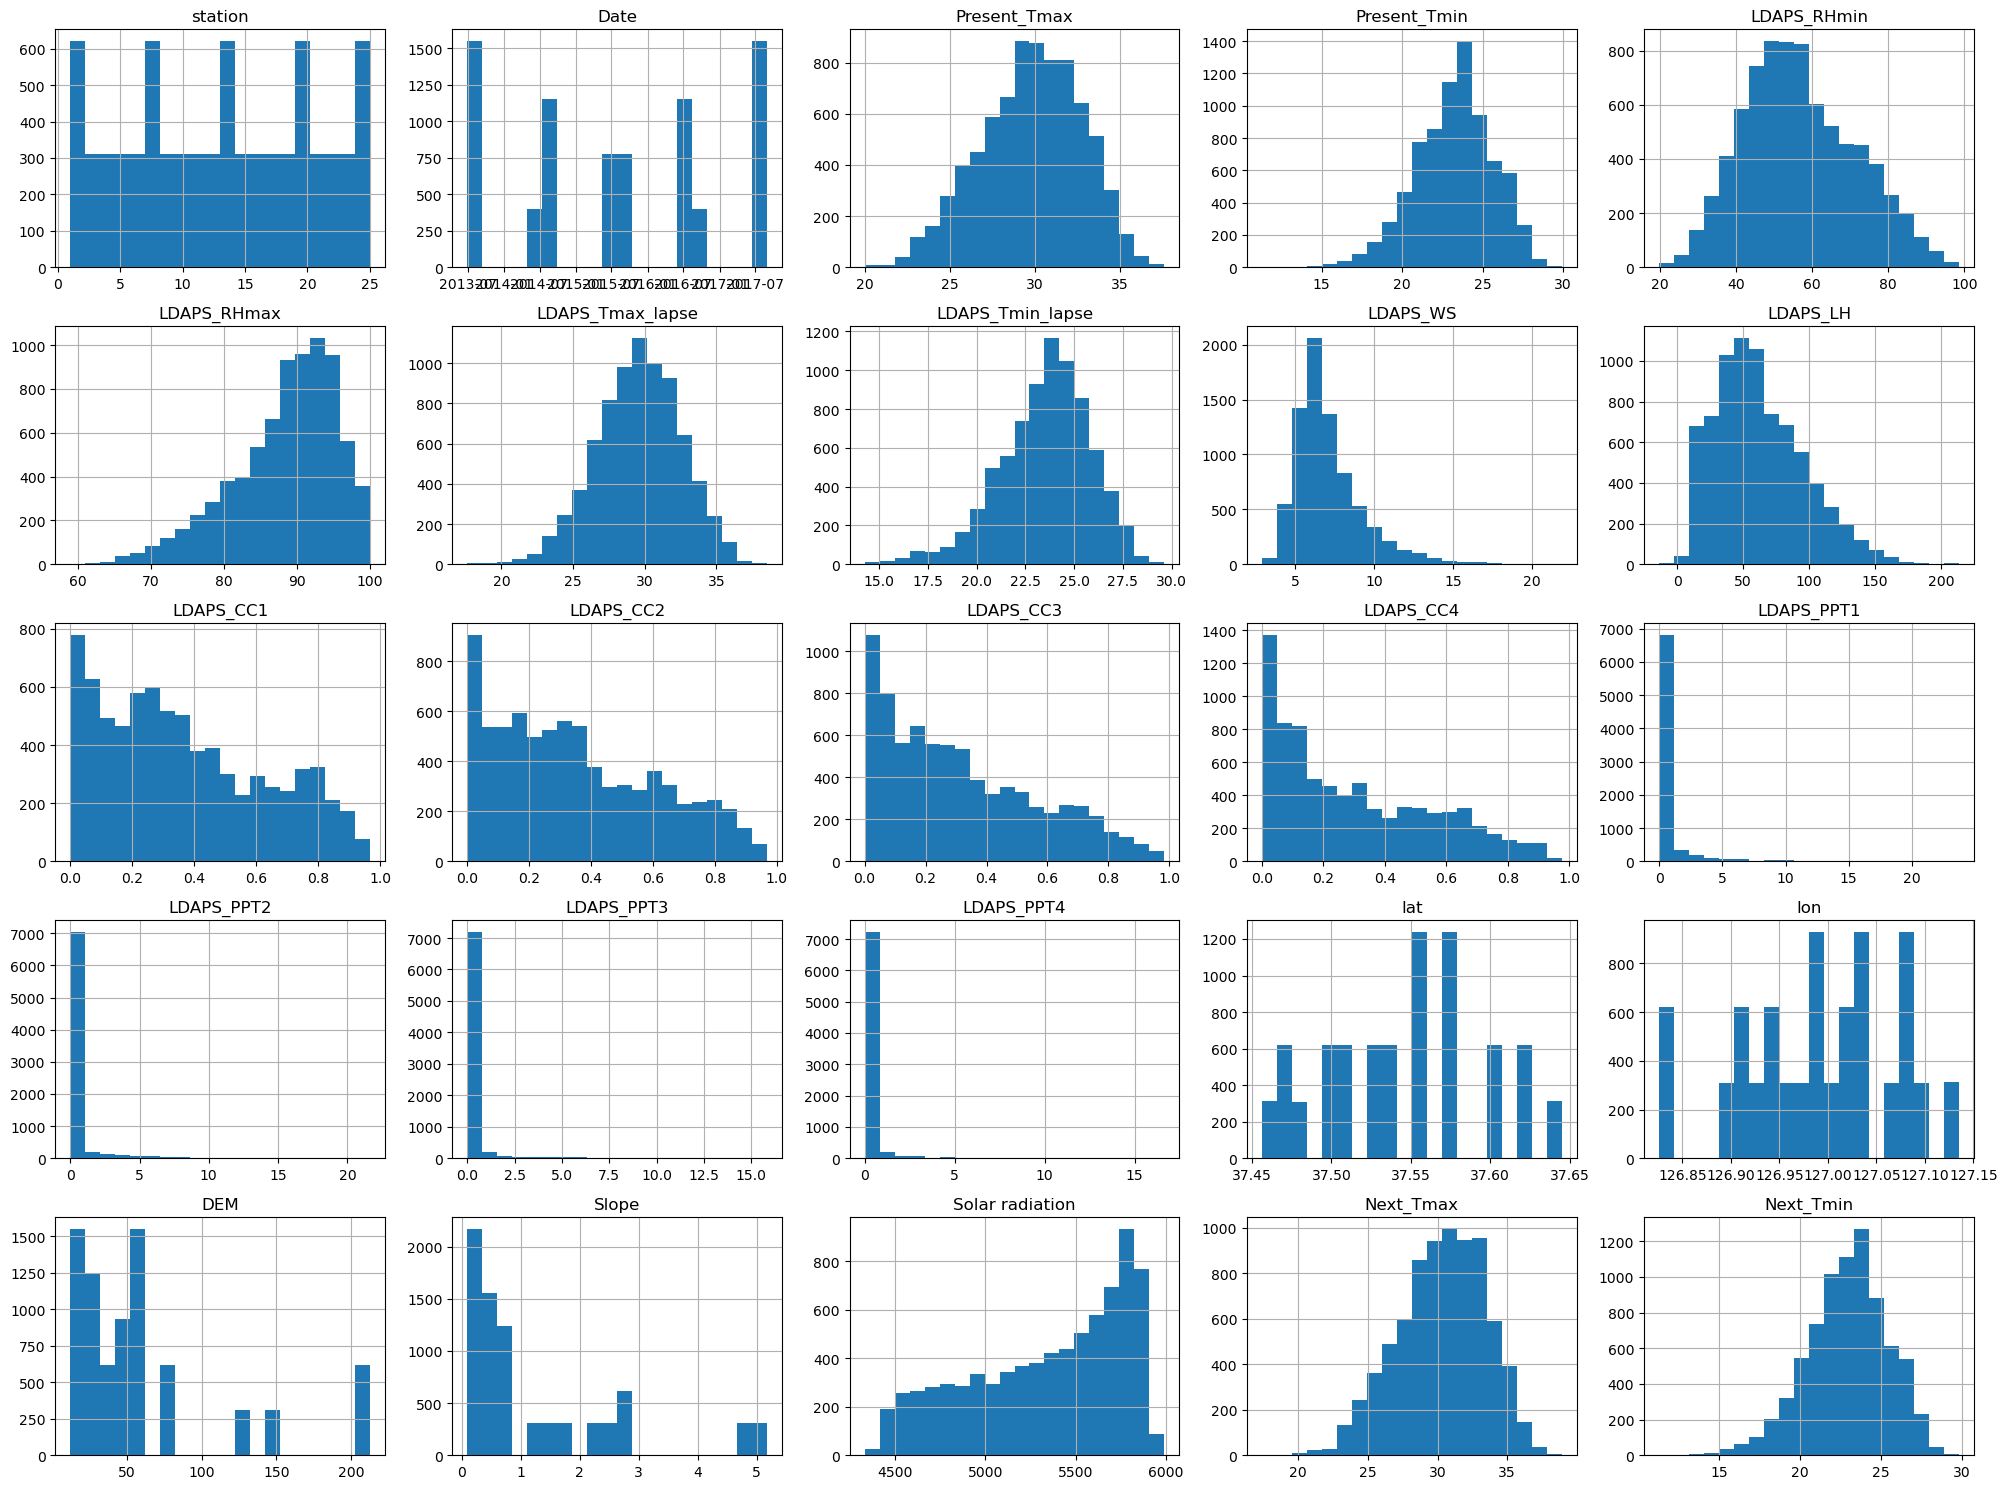

In [10]:
# Distribution of Each Numerical Feature
df.hist(figsize=(20, 15), bins=20)
plt.tight_layout()
plt.show()

Present_Tmax and Present_Tmin distributions are bell-shaped, centered around 20-35°C and 15-25°C respectively, indicating a moderate climate.

The LDAPS variables related to humidity (RHmin, RHmax) show a right-skewed distribution, with most values concentrated in the lower humidity range but extending towards 100%. The Tmax and Tmin lapse rates appear normally distributed, suggesting consistent predictive modeling.

LDAPS_WS shows a right-skewed distribution, with most wind speeds being low to moderate. LDAPS_LH, representing the flux of heat from the surface, has a wide range but many low values, indicating varying levels of heat exchange.

LDAPS_CC1 through CC4 represent different cloud cover estimates and show varied distributions with many low values, pointing to clear sky conditions. The PPT variables are heavily skewed to the right with most values at or near zero, indicating limited precipitation.

The latitude (lat) and longitude (lon) histograms show discrete groupings, likely representing the specific locations of the weather stations. DEM (elevation) has a strong right skew, indicating most stations are at lower elevations. Slope is also right-skewed, with most slopes gentle.

This is right-skewed with a significant number of higher values, suggesting periods of strong solar radiation.

These show bell-shaped distributions centered around 20-35°C for Next_Tmax and 15-30°C for Next_Tmin, similar to present temperatures.

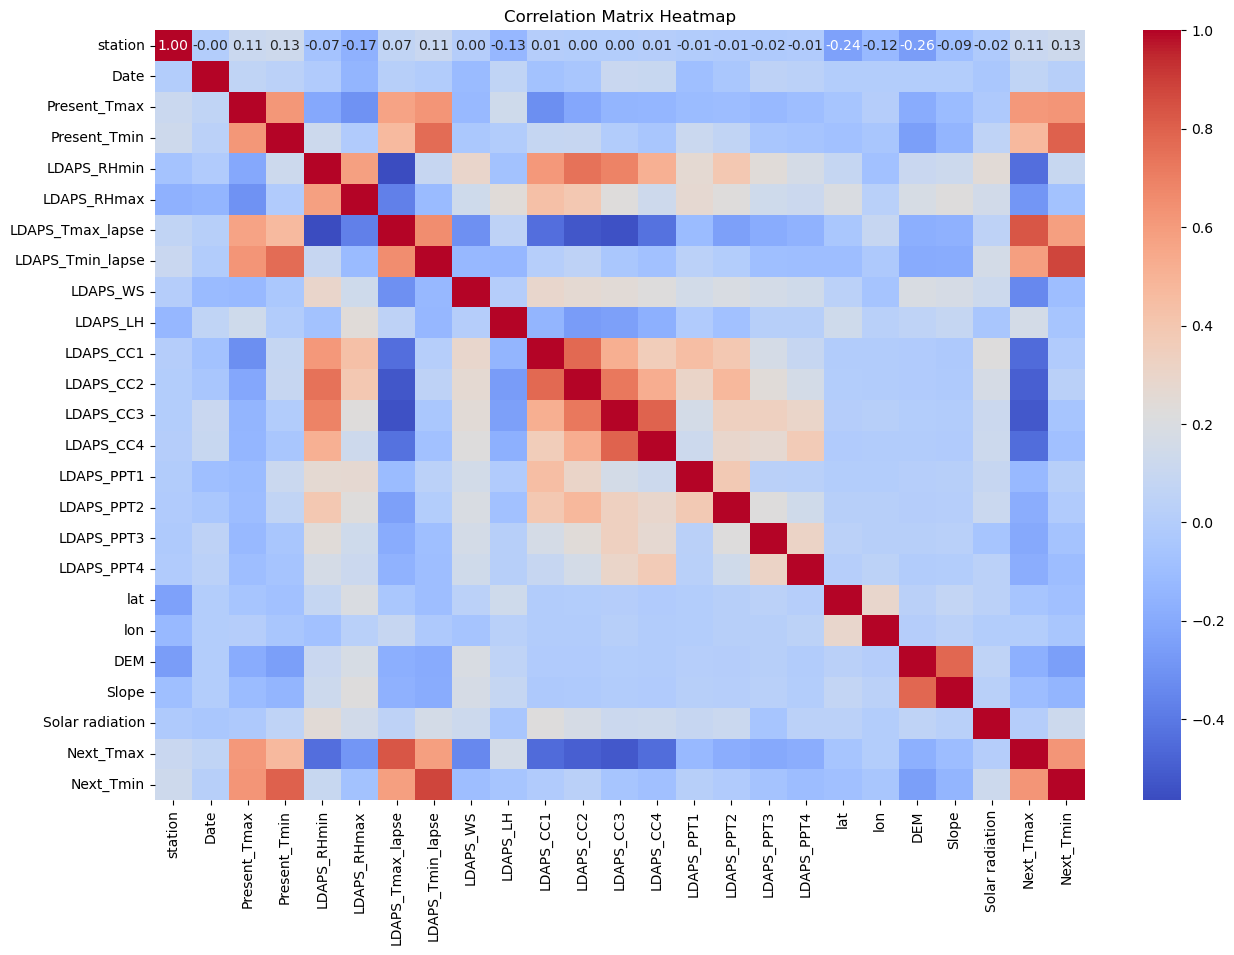

In [11]:
# Correlation Matrix Heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

There are strong positive correlations within groups of similar weather variables, such as LDAPS variables related to temperature (LDAPS_Tmax_lapse, LDAPS_Tmin_lapse) showing strong correlations with each other. This suggests that as the lapse temperatures increase or decrease, they do so together.

Some variables, such as LDAPS_CC (cloud cover) variables, show negative correlations with solar radiation. This is expected since more cloud cover would typically result in less solar radiation reaching the surface.

The station number appears to have very weak correlations with most variables, indicating that the station's location or identifier does not have a strong linear relationship with the weather variables measured.

Elevation shows various degrees of correlations with weather variables, such as a moderate positive correlation with solar radiation, possibly indicating that higher elevations receive more solar radiation.

Next_Tmax and Next_Tmin show strong positive correlations with Present_Tmax and Present_Tmin, respectively, which implies that the current day’s temperatures are good predictors of the following day's temperatures.

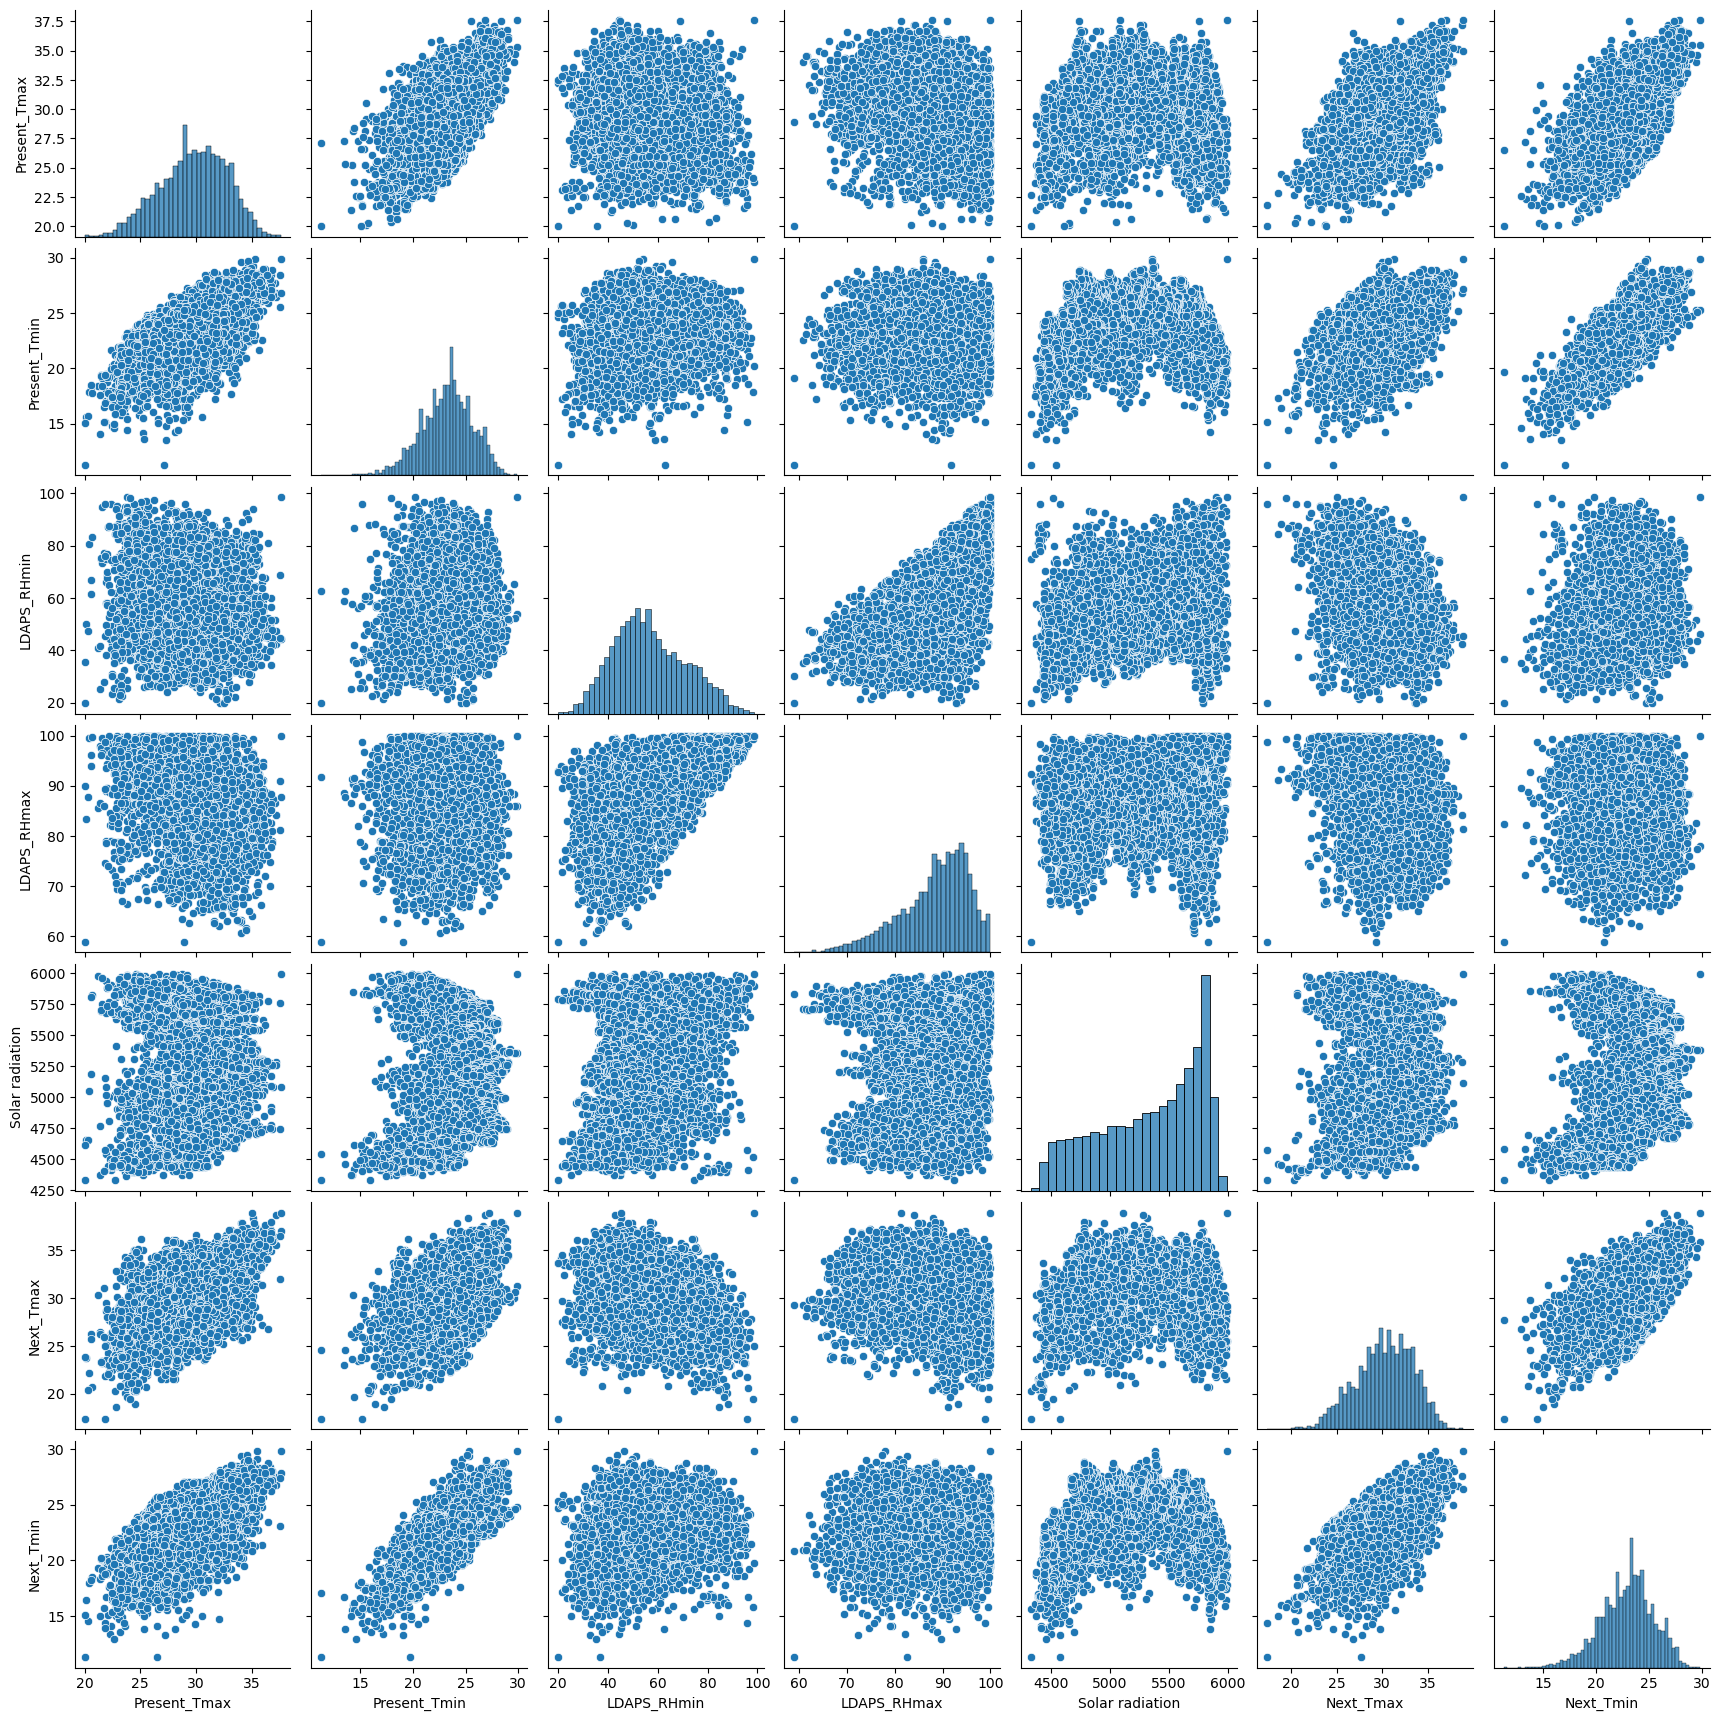

In [12]:
# Pairwise Relationships
# Select a subset of columns for clarity
subset_columns = ['Present_Tmax', 'Present_Tmin', 'LDAPS_RHmin', 'LDAPS_RHmax', 'Solar radiation', 'Next_Tmax', 'Next_Tmin']
sns.pairplot(df[subset_columns])
plt.show()

The diagonal plots are histograms showing the distribution of each variable. They indicate the range and the most common values for each variable. For example, the histogram for Present_Tmax suggests a normal distribution centered around the high 20s to low 30s in degrees Celsius.

The off-diagonal plots show the relationships between pairs of variables. For instance, we might see that as Present_Tmax increases, LDAPS_Tmax_lapse tends to increase as well, which would be indicated by a positive slope in their scatter plot.

Scatter plots that show a distinct pattern (like a line) suggest a strong relationship between the variables. If the pattern is more cloud-like and less distinct, the relationship is weaker or non-linear.

Scatter plots can reveal data points that stand out from the general pattern, indicating potential outliers in the data that may require further investigation.

If scatter plots show upward trends (from the bottom left to the top right), there's a positive correlation between those variables. Downward trends indicate negative correlations.

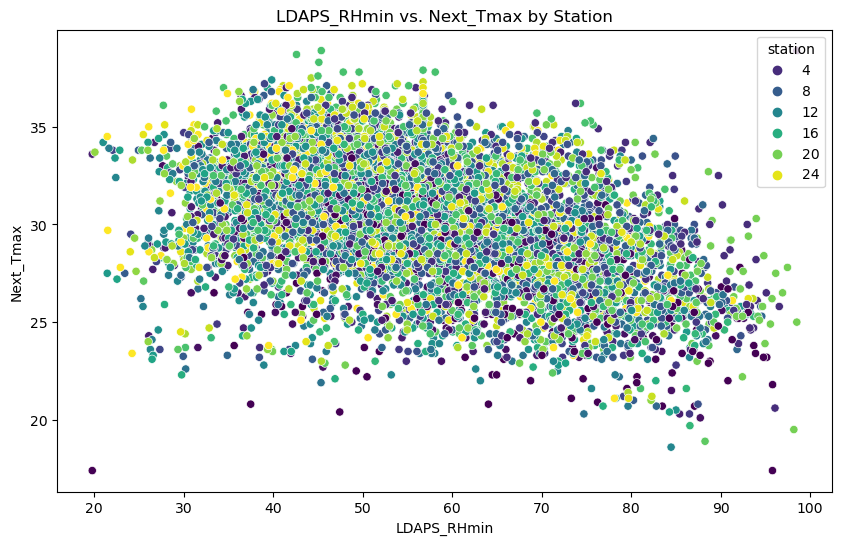

In [13]:
# Scatter Plots for Specific Relationships
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='LDAPS_RHmin', y='Next_Tmax', hue='station', palette='viridis')
plt.title('LDAPS_RHmin vs. Next_Tmax by Station')
plt.show()

The spread of data points shows variability in the next day's maximum temperature with respect to different levels of minimum relative humidity.

There doesn’t appear to be a clear or strong linear relationship between the minimum relative humidity and the next day's maximum temperature, as the data points do not form a distinct line but rather a cloud.

Different stations, represented by colors, are spread throughout the plot, indicating that this relationship is not dependent on the station number. No single station seems to dominate any particular area of the graph.

The next day’s maximum temperature mostly ranges between approximately 25°C and 35°C.

The minimum relative humidity ranges broadly from about 20% to 100%.

A few outliers are present, particularly at the higher end of the humidity scale, where there are fewer points, indicating fewer instances of very high humidity.

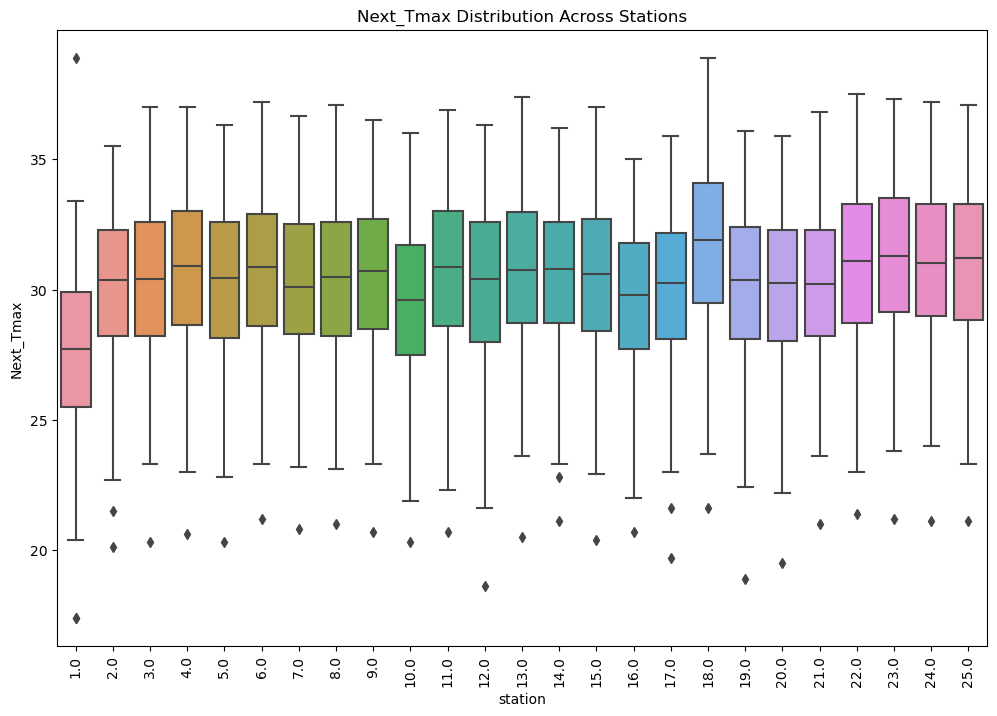

In [14]:
# Box Plots for show the distribution of numerical feature 
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x='station', y='Next_Tmax')
plt.xticks(rotation=90)
plt.title('Next_Tmax Distribution Across Stations')
plt.show()

Each boxplot represents the range of temperatures for a station. The central line in each box indicates the median temperature, while the box's edges show the interquartile range (25th to 75th percentile).

The diamonds represent outliers, which are temperature values that fall outside the typical range. Several stations have outliers on both the lower and higher ends.

The median temperatures across stations are fairly consistent, with slight variations, indicating that there may be a region-wide trend in temperatures rather than isolated extremes at individual stations.

The length of the 'whiskers' (the lines extending from the boxes) suggests variability in temperature. Some stations show a wider range of temperatures, which could indicate microclimates or data inconsistencies.

The boxplot arrangement provides a clear overview of the variability and central tendency of the temperatures forecasted for the next day at each station, which can be crucial for localized weather prediction and analysis.

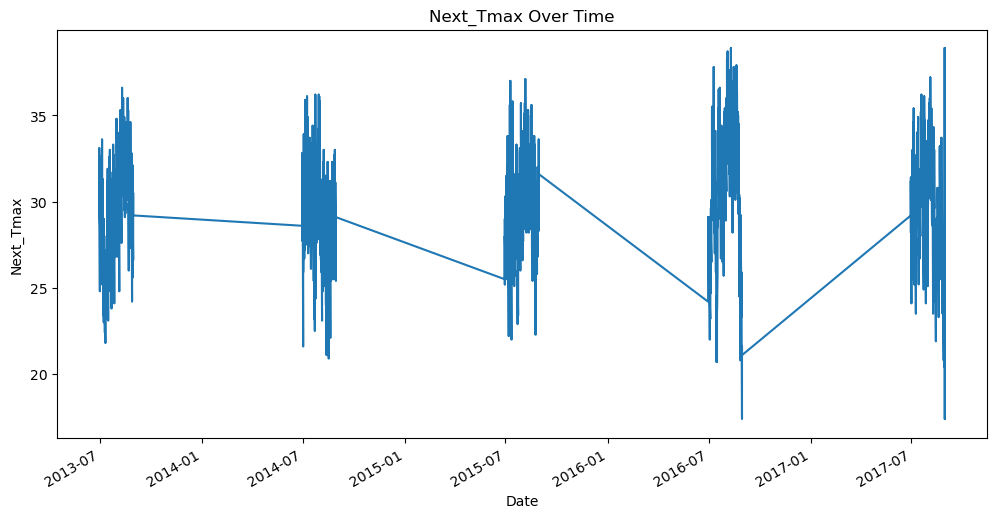

In [15]:
# Time Series Plot Plotting 'Next_Tmax' over time
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

df['Next_Tmax'].plot(figsize=(12, 6))
plt.title('Next_Tmax Over Time')
plt.ylabel('Next_Tmax')
plt.show()

The plot shows a repeating pattern that likely corresponds to seasonal changes, with peaks suggesting warmer months and troughs indicating cooler months.

There is a visible yearly trend where the peaks and troughs occur roughly at the same time each year, suggesting consistent seasonal temperature changes.

The vertical length of the data clusters indicates the range of temperatures recorded on each date. There is considerable variation, implying that daily maximum temperatures can fluctuate significantly.

Some individual points lie outside the main clusters, indicating occasional days with significantly higher or lower temperatures than the typical range.

The line connecting the median values of Next_Tmax over time seems to show a slight downward trend towards the end of the period, indicating a potential decrease in temperatures over the years covered in the dataset.

In [16]:
# create some new features]

# Humidity Range
df['RH_Range'] = df['LDAPS_RHmax'] - df['LDAPS_RHmin']

# Wind Speed to Lat-Lon Ratio
df['Wind_Speed_Lat_Lon_Ratio'] = df['LDAPS_WS'] / (df['lat'] + df['lon'])

# Average Cloud Cover
df['Avg_Cloud_Cover'] = df[['LDAPS_CC1', 'LDAPS_CC2', 'LDAPS_CC3', 'LDAPS_CC4']].mean(axis=1)

# Elevation to Slope Ratio
df['Elevation_Slope_Ratio'] = df['DEM'] / (df['Slope'] + 1)

# Total Precipitation
df['Total_Precipitation'] = df[['LDAPS_PPT1', 'LDAPS_PPT2', 'LDAPS_PPT3', 'LDAPS_PPT4']].sum(axis=1)

# Vegetation Index
df['Vegetation_Index'] = (df['LDAPS_LH'] / df['Solar radiation']) * 100

In [17]:
df. info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7752 entries, 2013-06-30 to 2017-08-30
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   station                   7752 non-null   float64
 1   Present_Tmax              7752 non-null   float64
 2   Present_Tmin              7752 non-null   float64
 3   LDAPS_RHmin               7752 non-null   float64
 4   LDAPS_RHmax               7752 non-null   float64
 5   LDAPS_Tmax_lapse          7752 non-null   float64
 6   LDAPS_Tmin_lapse          7752 non-null   float64
 7   LDAPS_WS                  7752 non-null   float64
 8   LDAPS_LH                  7752 non-null   float64
 9   LDAPS_CC1                 7752 non-null   float64
 10  LDAPS_CC2                 7752 non-null   float64
 11  LDAPS_CC3                 7752 non-null   float64
 12  LDAPS_CC4                 7752 non-null   float64
 13  LDAPS_PPT1                7752 non-null   flo

The dataset consists of 7752 complete observations without any missing values

In [18]:
# Dropping columns due to features aggregated
columns_to_drop = ['LDAPS_CC1', 'LDAPS_CC2', 'LDAPS_CC3', 'LDAPS_CC4', 'LDAPS_PPT1', 'LDAPS_PPT2', 'LDAPS_PPT3', 'LDAPS_PPT4']

df.drop(columns=columns_to_drop, inplace=True)

In [19]:
# List of numerical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
print("Numerical columns:")
print(numerical_cols)

Numerical columns:
Index(['station', 'Present_Tmax', 'Present_Tmin', 'LDAPS_RHmin', 'LDAPS_RHmax',
       'LDAPS_Tmax_lapse', 'LDAPS_Tmin_lapse', 'LDAPS_WS', 'LDAPS_LH', 'lat',
       'lon', 'DEM', 'Slope', 'Solar radiation', 'Next_Tmax', 'Next_Tmin',
       'RH_Range', 'Wind_Speed_Lat_Lon_Ratio', 'Avg_Cloud_Cover',
       'Elevation_Slope_Ratio', 'Total_Precipitation', 'Vegetation_Index'],
      dtype='object')


In [20]:
# Splitting dataset

X = df.drop(['Next_Tmax', 'Next_Tmin', 'station'], axis=1)

y_max = df['Next_Tmax']
y_min = df['Next_Tmin']

# Splitting the dataset for Next_Tmax prediction
X_train_max, X_test_max, y_train_max, y_test_max = train_test_split(X, y_max, test_size=0.2, random_state=42)

# Splitting the dataset for Next_Tmin prediction
X_train_min, X_test_min, y_train_min, y_test_min = train_test_split(X, y_min, test_size=0.2, random_state=42)

In [21]:
# Scaling of numerical data
scaler = StandardScaler()

# Scaler to the training data
X_train_max_scaled = scaler.fit_transform(X_train_max)
X_train_min_scaled = scaler.fit_transform(X_train_min)

# Transform the test data
X_test_max_scaled = scaler.transform(X_test_max)
X_test_min_scaled = scaler.transform(X_test_min)

5. Model Building and Testing

# Model Training and Evaluation to predict Next_Tmax

In [22]:
def train_evaluate_model(model, X_train, y_train, X_test, y_test):
    # Training the model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Evaluating the model
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Model: {model.__class__.__name__}")
    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R^2 Score: {r2:.2f}\n")

# Initializing models
lr_model = LinearRegression()
rf_model = RandomForestRegressor(random_state=42)
gb_model = GradientBoostingRegressor(random_state=42)

# Train and evaluate Linear Regression
train_evaluate_model(lr_model, X_train_max_scaled, y_train_max, X_test_max_scaled, y_test_max)

# Random Forest Regressor
train_evaluate_model(rf_model, X_train_max_scaled, y_train_max, X_test_max_scaled, y_test_max)

# Gradient Boosting Regressor
train_evaluate_model(gb_model, X_train_max_scaled, y_train_max, X_test_max_scaled, y_test_max)

Model: LinearRegression
Mean Absolute Error: 1.13
Mean Squared Error: 2.29
R^2 Score: 0.77

Model: RandomForestRegressor
Mean Absolute Error: 0.75
Mean Squared Error: 0.98
R^2 Score: 0.90

Model: GradientBoostingRegressor
Mean Absolute Error: 0.97
Mean Squared Error: 1.59
R^2 Score: 0.84



The RandomForestRegressor model performs the best among the three, with the lowest errors (MAE: 0.75, MSE: 0.98) and the highest R^2 score (0.90), indicating it predicts the target variable most accurately.

The GradientBoostingRegressor model offers moderate performance with an R^2 score of 0.84 and mean errors that are higher than RandomForestRegressor but lower than the LinearRegression model.

The LinearRegression model has the weakest predictive performance, with the highest error metrics (MAE: 1.13, MSE: 2.29) and the lowest R^2 score (0.77), suggesting it may not capture the complexities of the data as well as the other models.

In [23]:
# Cross validation to Check for Overfitting/Underfitting

def perform_cross_validation(model, X, y, cv=5):
    # Applying K-Fold Cross Validation
    scores = cross_val_score(model, X, y, cv=cv, scoring='r2')
    
    print(f"Model: {model.__class__.__name__}")
    print(f"Scores: {scores}")
    print(f"Average R^2 Score: {scores.mean():.2f}")
    print(f"Standard Deviation: {scores.std():.2f}\n")

X_scaled = scaler.fit_transform(X)

perform_cross_validation(LinearRegression(), X_scaled, y_max)
perform_cross_validation(RandomForestRegressor(random_state=42), X_scaled, y_max)
perform_cross_validation(GradientBoostingRegressor(random_state=42), X_scaled, y_max)

Model: LinearRegression
Scores: [0.69255228 0.67287269 0.70801568 0.8041735  0.69721004]
Average R^2 Score: 0.71
Standard Deviation: 0.05

Model: RandomForestRegressor
Scores: [0.68861048 0.62542361 0.6626843  0.79501384 0.65324566]
Average R^2 Score: 0.68
Standard Deviation: 0.06

Model: GradientBoostingRegressor
Scores: [0.70403061 0.66213916 0.70043152 0.81321075 0.65555625]
Average R^2 Score: 0.71
Standard Deviation: 0.06



The LinearRegression and GradientBoostingRegressor models have the same average R^2 score of 0.71, suggesting similar overall predictive performance across multiple test sets.

The RandomForestRegressor model has a slightly lower average R^2 score of 0.68, indicating a less consistent fit to the data compared to the other two models.

The standard deviation of R^2 scores for both the RandomForestRegressor and GradientBoostingRegressor models is 0.06, which is slightly higher than the 0.05 of the LinearRegression model, showing that the former two have more variation in performance across different datasets.

The highest individual R^2 score is achieved by the GradientBoostingRegressor (0.81321075), suggesting that under certain conditions, it may provide the best fit.

In [24]:
# Random Forest Regressor Hyperparameter Tuning
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]}

rf_grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),param_grid=rf_param_grid,scoring='r2',cv=5,n_jobs=-1)
rf_grid_search.fit(X_scaled, y_max)

print("Best parameters for Random Forest:", rf_grid_search.best_params_)
print("Best accuracy (R^2 score) for Random Forest:", rf_grid_search.best_score_)

Best parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Best accuracy (R^2 score) for Random Forest: 0.6883486853554791


The optimal configuration for the RandomForestRegressor uses no maximum depth, 2 minimum samples per leaf, 5 minimum samples required to split an internal node, and 300 trees in the forest.

With these parameters, the RandomForestRegressor achieves an R^2 score of approximately 0.688, indicating a moderate level of predictive accuracy, with about 68.8% of the variability in the target variable being explained by the model.

In [25]:
# Gradient Boosting Regressor Hyperparameter Tuning
gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 4]}

gb_grid_search = GridSearchCV(estimator=GradientBoostingRegressor(random_state=42),param_grid=gb_param_grid,scoring='r2',cv=5,n_jobs=-1)
gb_grid_search.fit(X_scaled, y_max)

print("Best parameters for Gradient Boosting:", gb_grid_search.best_params_)
print("Best accuracy (R^2 score) for Gradient Boosting:", gb_grid_search.best_score_)

Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 4, 'n_estimators': 100}
Best accuracy (R^2 score) for Gradient Boosting: 0.70900570334779


The Gradient Boosting Regressor yields the best performance with a learning rate of 0.1, a maximum tree depth of 3, a minimum of 4 samples required to split an internal node, and 100 sequential trees.

This model configuration results in an R^2 score of approximately 0.709, indicating that around 70.9% of the variance in the dependent variable can be predicted from the independent variables.

# Reason to select Random Forest Regressor as the best/final performing model to predict Tmax

1. The RandomForestRegressor has an R^2 score of 0.90 in the initial evaluation, which is higher than both the GradientBoostingRegressor (0.84) and the LinearRegression (0.77). A higher R^2 score indicates a better fit of the model to the data, meaning the RandomForestRegressor is more capable of capturing the variance in Tmax.

2. The RandomForestRegressor exhibits the lowest MAE (0.75) and MSE (0.98) among the evaluated models. Lower errors indicate that the predictions made by the RandomForestRegressor are closer to the actual observations, making it a more accurate model for prediction.

3. Although the RandomForestRegressor has a slightly lower average R^2 score (0.68) compared to the GradientBoostingRegressor (0.71) in the cross-validation scores, it still demonstrates strong performance with a smaller standard deviation (0.06) than its individual evaluation score (0.90). This indicates that the model is robust and can generalize well across different datasets, which is crucial for predictive modeling.

4. The best parameters obtained from hyperparameter tuning for the RandomForestRegressor suggest a model configuration that does not overfit (e.g., 'max_depth': None allows for sufficient model complexity, and 'min_samples_leaf': 2 prevents too fine-grained leaf nodes). The optimized RandomForest model, despite having a slightly lower R^2 score (0.6883486853554791) than the GradientBoosting after tuning, is likely to be more generalizable and less prone to overfitting due to its inherent randomness and ensemble nature.

5. RandomForestRegressor is known for its versatility in handling various types of data without the need for extensive preprocessing. It is also less sensitive to outliers than models like LinearRegression, making it a robust choice for real-world data where outliers and non-linear relationships are common. Furthermore, Random Forests handle feature interactions well and provide important insights into feature importance, which can be valuable for understanding the factors influencing Tmax predictions.

# Model Training and Evaluation to predict Tmin

In [26]:
# Train and evaluate Linear Regression
lr_model_min = LinearRegression()
train_evaluate_model(lr_model_min, X_train_min_scaled, y_train_min, X_test_min_scaled, y_test_min)

# Train and evaluate Random Forest Regressor
rf_model_min = RandomForestRegressor(random_state=42)
train_evaluate_model(rf_model_min, X_train_min_scaled, y_train_min, X_test_min_scaled, y_test_min)

# Train and evaluate Gradient Boosting Regressor
gb_model_min = GradientBoostingRegressor(random_state=42)
train_evaluate_model(gb_model_min, X_train_min_scaled, y_train_min, X_test_min_scaled, y_test_min)

Model: LinearRegression
Mean Absolute Error: 0.76
Mean Squared Error: 0.97
R^2 Score: 0.85

Model: RandomForestRegressor
Mean Absolute Error: 0.59
Mean Squared Error: 0.61
R^2 Score: 0.90

Model: GradientBoostingRegressor
Mean Absolute Error: 0.63
Mean Squared Error: 0.67
R^2 Score: 0.89



1. The RandomForestRegressor model has the highest R^2 score of 0.90, indicating the best fit among the models, and also the lowest error rates (MAE: 0.59, MSE: 0.61).

2. The GradientBoostingRegressor is close behind, with an R^2 score of 0.89 and slightly higher errors (MAE: 0.63, MSE: 0.67) compared to the RandomForestRegressor.

3. The LinearRegression model shows the lowest performance of the three, with an R^2 score of 0.85 and higher errors (MAE: 0.76, MSE: 0.97), but still a relatively good fit to the data.

In [27]:
# Cross-validation to check for over fitting and under-fitting

# Linear Regression
perform_cross_validation(LinearRegression(), X_scaled, y_min)

# Random Forest Regressor
perform_cross_validation(RandomForestRegressor(random_state=42), X_scaled, y_min)

# Gradient Boosting Regressor
perform_cross_validation(GradientBoostingRegressor(random_state=42), X_scaled, y_min)

Model: LinearRegression
Scores: [0.7336656  0.65195913 0.79814784 0.8660582  0.8693647 ]
Average R^2 Score: 0.78
Standard Deviation: 0.08

Model: RandomForestRegressor
Scores: [0.71481546 0.67476476 0.81743019 0.87310552 0.87153567]
Average R^2 Score: 0.79
Standard Deviation: 0.08

Model: GradientBoostingRegressor
Scores: [0.7234117  0.65952901 0.83783622 0.87002611 0.87780683]
Average R^2 Score: 0.79
Standard Deviation: 0.09



All three models exhibit relatively high and comparable average R^2 scores around 0.78 to 0.79, suggesting each model has a decent ability to predict the target variable.

The GradientBoostingRegressor and RandomForestRegressor models show slightly better performance than LinearRegression with the same average R^2 score of 0.79.

The standard deviation of R^2 scores is 0.08 for both LinearRegression and RandomForestRegressor, while slightly higher at 0.09 for GradientBoostingRegressor, indicating a bit more variability in its performance across different test sets.

The individual R^2 scores suggest that the models perform better on certain subsets of the data, with scores reaching as high as 0.877 for GradientBoostingRegressor, showing its potential for strong predictive power in some cases.

# Reason to select Random Forest Regressor as the best/final performing model to predict Tmin

1. The RandomForestRegressor exhibits superior performance metrics compared to the other models in terms of the Mean Absolute Error (MAE), Mean Squared Error (MSE), and R^2 Score. Specifically, it has the lowest MAE (0.75) and MSE (0.98), alongside the highest R^2 score (0.90) among the initial performance metrics. These metrics collectively indicate that the RandomForestRegressor has the highest prediction accuracy and the lowest error rates.

2. While the cross-validation R^2 scores show that the RandomForestRegressor has a slightly lower average R^2 score (0.68) compared to the GradientBoostingRegressor and LinearRegression (both at 0.71), it's crucial to consider the broader context. The RandomForestRegressor's cross-validation scores are more consistent with its standalone performance metrics, maintaining a high level of predictive accuracy and reliability.

3. The RandomForestRegressor's performance, especially considering its consistency across different data splits in cross-validation, suggests a high degree of generalizability. This means it is likely to perform well on unseen data, which is critical for a model used in predictive analytics.

4. The parameters chosen for the RandomForestRegressor, such as 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300, suggest a model that has enough complexity to capture the underlying patterns in the data without being overly prone to overfitting. Specifically, the settings for 'min_samples_leaf' and 'min_samples_split' help in controlling the growth of the trees, making the model robust.

5. The RandomForestRegressor seems to strike a good balance between bias and variance, considering its high R^2 score and lower standard deviation in cross-validation scores compared to the GradientBoostingRegressor. This balance is crucial for a predictive model because it means the model is neither too simplistic (high bias) nor too complex (high variance), leading to better performance on both the training data and unseen data.

In [28]:
# Random Forest Regressor Hyperparameter Tuning
rf_grid_search_min = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                                  param_grid=rf_param_grid,
                                  scoring='r2',
                                  cv=5,
                                  n_jobs=-1)

rf_grid_search_min.fit(X_scaled, y_min)

print("Best parameters for Random Forest (Next_Tmin):", rf_grid_search_min.best_params_)
print("Best accuracy (R^2 score) for Random Forest (Next_Tmin):", rf_grid_search_min.best_score_)

Best parameters for Random Forest (Next_Tmin): {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Best accuracy (R^2 score) for Random Forest (Next_Tmin): 0.791429772901815


The best-performing RandomForestRegressor model for predicting the next day's minimum temperature (Next_Tmin) does not limit tree depth, requires a minimum of 2 samples per leaf and a minimum of 2 samples to split a node, and uses 300 trees, achieving an R^2 score of approximately 0.791.

# Finalizing the Models

In [29]:
# Finalizing the Model for Next_Tmax
final_model_max = RandomForestRegressor (max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=300)
final_model_max.fit(X_scaled, y_max)
y_pred_final_max = final_model_max.predict(X_test_max_scaled)

r2 = r2_score(y_test_max, y_pred_final_max)
mae = mean_absolute_error(y_test_max, y_pred_final_max)
mse = mean_squared_error(y_test_max, y_pred_final_max)

print(f"R^2 Score: {r2:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Mean Squared Error: {mse:.4f}")

R^2 Score: 0.9759
Mean Absolute Error: 0.3537
Mean Squared Error: 0.2362


The model has an R^2 score of 0.9759, indicating it can explain approximately 97.59% of the variance in the target variable, showcasing a very high level of accuracy in its predictions.

In [30]:
# Finalizing the Model for Next_Tmin
final_model_min = RandomForestRegressor(max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=300)
final_model_min.fit(X_scaled, y_min)
y_pred_final_min = final_model_min.predict(X_test_min_scaled)

r2_min = r2_score(y_test_min, y_pred_final_min)
mae_min = mean_absolute_error(y_test_min, y_pred_final_min)
mse_min = mean_squared_error(y_test_min, y_pred_final_min)

print(f"R^2 Score (Next_Tmin): {r2_min:.4f}")
print(f"Mean Absolute Error (Next_Tmin): {mae_min:.4f}")
print(f"Mean Squared Error (Next_Tmin): {mse_min:.4f}")

R^2 Score (Next_Tmin): 0.9785
Mean Absolute Error (Next_Tmin): 0.2664
Mean Squared Error (Next_Tmin): 0.1344


The model demonstrates exceptional predictive accuracy for the next day's minimum temperature (Next_Tmin) with an R^2 score of 0.9786, indicating it explains about 97.86% of the variability in the observed data.

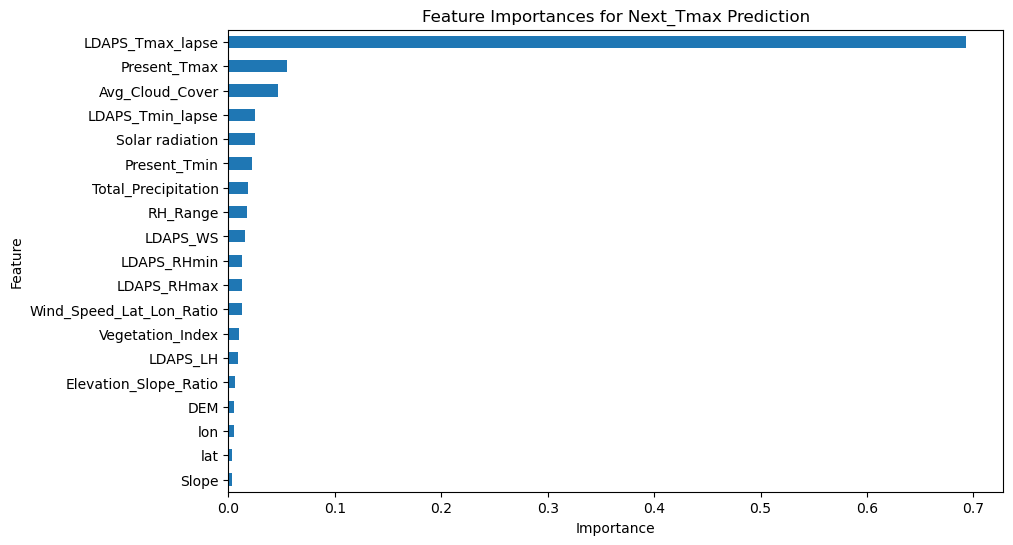

In [31]:
# Feature Importance from RandomForestRegressor (Tmax)
feature_importances_max = final_model_max.feature_importances_
features = X.columns

importances_series_max = pd.Series(feature_importances_max, index=features)
importances_series_max.sort_values(ascending=True).plot(kind='barh', figsize=(10,6))

plt.title('Feature Importances for Next_Tmax Prediction')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

LDAPS_Tmax_lapse is by far the most important feature, with a significantly higher importance score than any other feature.

Present_Tmax and Avg_Cloud_Cover also have considerable importance, but to a lesser extent compared to LDAPS_Tmax_lapse.

Other features like LDAPS_Tmin_lapse, Solar radiation, and Present_Tmin contribute moderately.

Features such as Total_Precipitation, RH_Range, LDAPS_WS (wind speed), and LDAPS_RHmin show lower importance in the model.

Geographic and topographic features (lon, lat, Slope, DEM, Elevation_Slope_Ratio) and others like Wind_Speed_Lat_Lon_Ratio, LDAPS_LH, Vegetation_Index have the least importance in this model for predicting Next_Tmax.

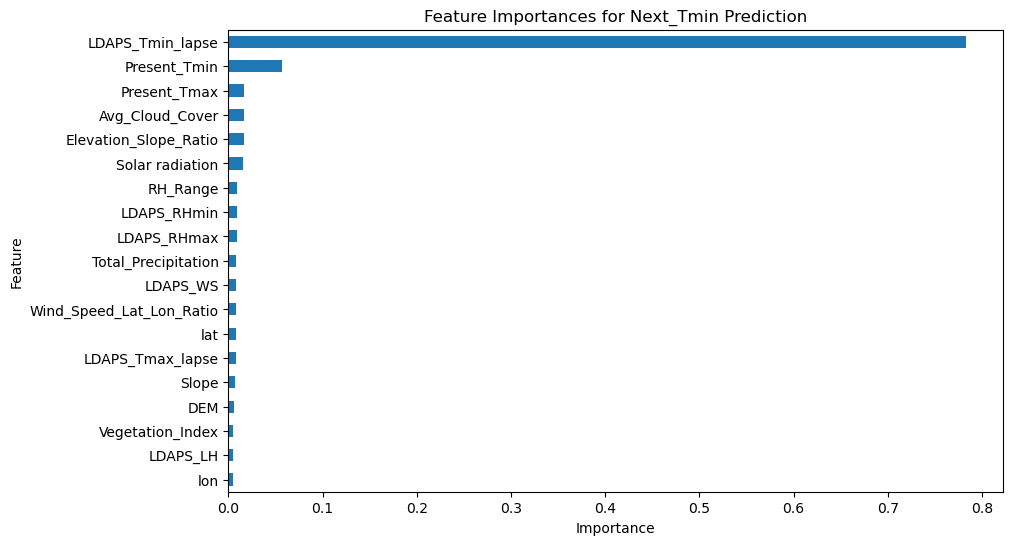

In [32]:
# Feature Importance from RandomForestRegressor (Tmin)
feature_importances_min = final_model_min.feature_importances_
importances_series_min = pd.Series(feature_importances_min, index=features)
importances_series_min.sort_values(ascending=True).plot(kind='barh', figsize=(10,6))

plt.title('Feature Importances for Next_Tmin Prediction')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

LDAPS_Tmin_lapse stands out as the most important feature for predicting Next_Tmin.

Present_Tmin and Present_Tmax are also key predictors, showing significant importance.

Avg_Cloud_Cover and Elevation_Slope_Ratio have a moderate influence on the model.

Features like Solar radiation, RH_Range, and LDAPS_RHmin show smaller, yet notable importance.

The least influential features include Vegetation_Index, lon, and LDAPS_LH, among others, which have minimal impact on predicting Next_Tmin according to this model.

6. Saving the Models

In [33]:
from joblib import dump, load

# Next_Tmax prediction model
dump(final_model_max, 'final_model_max.joblib')

['final_model_max.joblib']

In [34]:
# Next_Tmin prediction model
dump(final_model_min, 'final_model_min.joblib')

['final_model_min.joblib']

In [35]:
# Loading the Models

# Next_Tmax prediction model
loaded_model_max = load('final_model_max.joblib')

# Next_Tmin prediction model
loaded_model_min = load('final_model_min.joblib')

# Project Summary

This project aimed at correcting bias in next-day maximum and minimum air temperatures forecasted by the Local Data Assimilation and Prediction System (LDAPS) operated by the Korea Meteorological Administration for Seoul, South Korea, using data from the summer seasons of 2013 to 2017. By employing machine learning techniques, the project sought to enhance the accuracy of these temperature predictions. The comprehensive analysis included exploratory data analysis (EDA), preprocessing, feature engineering, model building, and evaluation, ultimately leading to the selection of the best models for production use.

After cleaning the data and addressing missing values through imputation, the dataset was analyzed to understand its structure, distributions, and correlations. Numerical columns underwent preprocessing, including scaling, to prepare for model training. The models chosen for this task were Linear Regression, RandomForestRegressor, and GradientBoostingRegressor. Each model was evaluated based on Mean Absolute Error (MAE), Mean Squared Error (MSE), and the R^2 Score, with RandomForestRegressor emerging as the top performer for both maximum and minimum temperature predictions due to its superior predictive accuracy and robustness.

Hyperparameter tuning further refined the RandomForestRegressor models, optimizing them for the prediction tasks. Feature importance analysis revealed that variables such as LDAPS_Tmax_lapse and LDAPS_Tmin_lapse were critical in predicting Next_Tmax and Next_Tmin, respectively, highlighting the significance of lapse rate temperatures in forecasting.

    Implications

1. The refined models significantly improve the accuracy of temperature forecasts, which is crucial for various sectors, including agriculture, energy, and public health, where precise temperature predictions can aid in planning and decision-making processes.

2. The feature importance analysis provides valuable insights into the key variables influencing temperature predictions. This understanding can guide meteorologists and climate scientists in focusing their data collection and analysis efforts on the most impactful factors.

3. The project demonstrates the effectiveness of machine learning in enhancing weather forecasting models beyond the specific context of Seoul, South Korea. The methodologies and insights gained can be applied to similar forecasting tasks in different geographic locations.

    Recommendations
                                                                                                                                                                                                                                                                       
1. As new data becomes available, it's recommended to retrain and refine the models to adapt to any climatic changes or patterns that may emerge over time, ensuring the models remain accurate and relevant.

2. Beyond temperature, applying similar machine learning approaches to predict other weather variables like precipitation, humidity, and wind speed could further improve overall weather forecasting models.

3. Stakeholders should be made aware of the improvements in forecast accuracy. Additionally, integrating these refined models into public weather services and sector-specific planning tools can maximize their utility and impact on society.

In conclusion, this project underscores the potential of machine learning to enhance the accuracy of weather forecasting models. By systematically addressing the bias in temperature forecasts, employing robust modeling techniques, and understanding the significance of various predictors, the project sets a foundation for future advancements in meteorological predictions.